# Introduction


In [ ]:
#install.packages(c('gridExtra', 'car','tidyr'))
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(gridExtra)
library(car)
library(tidyr)

This dataset contains detailed information on houses sold in Seattle, Washington, USA, between August and December 2022. Although it represents one of the most recent datasets available, it is important to acknowledge potential discrepancies relative to current market conditions.

The data is originally sourced from the following link: [https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle](https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle)

The following variables are recorded in the dataset:

| Variable       | Description                                                                    | Datatype    |
| -------------- | ------------------------------------------------------------------------------ | ----------- |
| beds           | Number of bedrooms in property,                                                | Numerical   |
| baths          | Number of bathrooms in property (0.5 indicates a bathroom without shower area) | Numerical   |
| size           | Total floor area of property (sqft)                                            | Numerical   |
| size_units     | Units of the previous measurement (sqft)                                       | Categorical |
| lot_size       | Total area of the land where the property is located (sqft/acres)              | Numerical   |
| lot_size_units | Units of the previous measurement (sqft/acres)                                 | Categorical |
| zip_code       | Zip code. This is a postal code used in the USA                                | Categorical   |
| price          | Price the property was sold for (US dollars)                                   | Numerical   |

This study seeks to address the following research question:

$$\text{"How do various covariates, such as physical and geographical features, correlate with the market price of houses in Seattle?"}$$

Motivation:
- Seattle is one of North America’s fastest growing and developing cities and it has a lot of promising job opportunities, particularly in the STEM fields which many STATs students see as an option to settle down in. Especially for BC residents, this is a great option since it’s very close to the province.
- Understanding the housing market is crucial for prospective residents, buyers, and investors. This study aims to uncover relationships between housing features and market prices to provide valuable insights into the Seattle housing market.


##Load the data

The datasets are loaded via the github link so, anyone can load the datasets without relying on the local `train.csv` and `test.csv` files, however, the data in the github matches the one provided in the submitted local files.

In [ ]:
# get datasets online (no reliance on local files)
train <- read.csv('https://raw.githubusercontent.com/PUSH-YA/house_pricing_inference/refs/heads/main/train.csv')
test <- read.csv('https://raw.githubusercontent.com/PUSH-YA/house_pricing_inference/refs/heads/main/test.csv')

# combine the data to form one dataset
data <- rbind(train, test)

# check na values
sum(is.na(data))

# check categorical values
cat('\n unique values of size units:', unique(data$size_units), '\n unique values of lot size units:', unique(data$lot_size_units), '\n number of unique zip codes:', length(unique(data$zip_code)))
summary(data)

[1] 424


 unique values of size units: sqft 
 unique values of lot size units: sqft acre  
 number of unique zip codes: 29

      beds            baths            size        size_units       
 Min.   : 1.000   Min.   :0.500   Min.   :  250   Length:2521       
 1st Qu.: 2.000   1st Qu.:1.500   1st Qu.: 1086   Class :character  
 Median : 3.000   Median :2.000   Median : 1580   Mode  :character  
 Mean   : 2.877   Mean   :2.172   Mean   : 1759                     
 3rd Qu.: 4.000   3rd Qu.:2.500   3rd Qu.: 2270                     
 Max.   :15.000   Max.   :9.000   Max.   :11010                     
                                                                    
    lot_size       lot_size_units        zip_code         price         
 Min.   :   0.23   Length:2521        Min.   :98101   Min.   :  159000  
 1st Qu.:1263.00   Class :character   1st Qu.:98108   1st Qu.:  605000  
 Median :4001.00   Mode  :character   Median :98117   Median :  813000  
 Mean   :3896.25                      Mean   :98124   Mean   :  966822  
 3rd Qu.:6000.00                      3rd Qu.:98126   3rd Qu.: 1115000  
 Max.   :9

## Data Preprocessing
The dataset required several preprocessing steps to ensure consistency and interpretability:

1. Unit Conversion:
- `lot_size`, includes properties measured originally in both `sqft` and `acre`, were converted entirely to `sqft` for uniformity.
- Columns `lot_size_unit` and `size_unit` which specify units, were removed after conversion of the `lot_size` and `size` of all properties to `sqft`.
2. Handling Missing Data:
- Rows with `NA` values were removed. Linear regression requires complete data to produce unbiased coefficients and valid inferences. Missing values could lead to inaccurate predictions and incorrect conclusions.
3. Mapping `zip_code` to `neighborhood`:
- `zip_code` were mapped to corresponding `neighborhood` based on online resources. This improves interpretability for readers unfamiliar with Seattle ZIP codes and simplifies the analysis.
- Some ZIP codes within the same neighborhood were grouped to address imbalances in the dataset, as certain ZIP codes had very few observations.

These steps ensured the dataset was standardized and representative, enabling accurate and meaningful analysis.


In [ ]:
# Convert lot size from acres to square feet where applicable
data <- data %>%
  mutate(lot_size = ifelse(lot_size_units == 'acre', lot_size * 43560, lot_size))

# ZIP code to Neighborhood mapping
zip_to_area <- data.frame(
  zip_code = c(98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98112,
               98115, 98116, 98117, 98118, 98119, 98121, 98122, 98125, 98126, 98133,
               98136, 98144, 98146, 98164, 98168, 98177, 98178, 98188, 98199),
  neighborhood = c("Downtown", "Cascade", "Green Lake", "Downtown", "University District",
               "Delridge", "Ballard", "Georgetown", "Cascade", "Central Area",
               "Bryant", "West Seattle", "Ballard", "Rainier Valley", "Queen Anne", "Downtown",
               "Central Area", "Lake City", "Delridge", "North Seattle", "West Seattle",
               "Central Area", "South Seattle", "Downtown", "South Seattle", "North Seattle", "South Seattle",
               "South Seattle", "Magnolia")
)

# Create new column for neighborhood which is mapped based on zip code
data <- data %>%
  left_join(zip_to_area, by = "zip_code")

# Convert neighborhood to categorical variable
data$neighborhood <- as.factor(data$neighborhood)

# Remove units and zip codes
data <- data %>% dplyr::select(-lot_size_units, -size_units, -zip_code)

# Remove missing values
clean_data <- na.omit(data)
summary(clean_data)

      beds            baths            size          lot_size       
 Min.   : 1.000   Min.   :0.500   Min.   :  250   Min.   :     500  
 1st Qu.: 2.000   1st Qu.:1.500   1st Qu.: 1280   1st Qu.:    3000  
 Median : 3.000   Median :2.000   Median : 1740   Median :    5000  
 Mean   : 3.137   Mean   :2.305   Mean   : 1917   Mean   :   16784  
 3rd Qu.: 4.000   3rd Qu.:3.000   3rd Qu.: 2390   3rd Qu.:    7407  
 Max.   :15.000   Max.   :9.000   Max.   :11010   Max.   :10890000  
                                                                    
     price                 neighborhood
 Min.   :  159000   Central Area :286  
 1st Qu.:  685000   Ballard      :270  
 Median :  870000   Green Lake   :187  
 Mean   : 1039809   Delridge     :183  
 3rd Qu.: 1180000   Bryant       :175  
 Max.   :25000000   South Seattle:157  
                    (Other)      :839  

# Analysis
## Exploratory Data Analysis ($EDA$)
Exploratory Data Analysis (EDA) is performed to visually examine the relationships between covariates and the response variable. This process provides insights that help guide our decisions when constructing linear regression models, ensuring they accurately capture the underlying data patterns.

To begin, we examine the distribution of price to identify potential extreme values. Outliers in the price variable can significantly impact model interpretability and may need to be addressed to prevent distortion of results.

 1.5*IQR + Q3 is 2293750

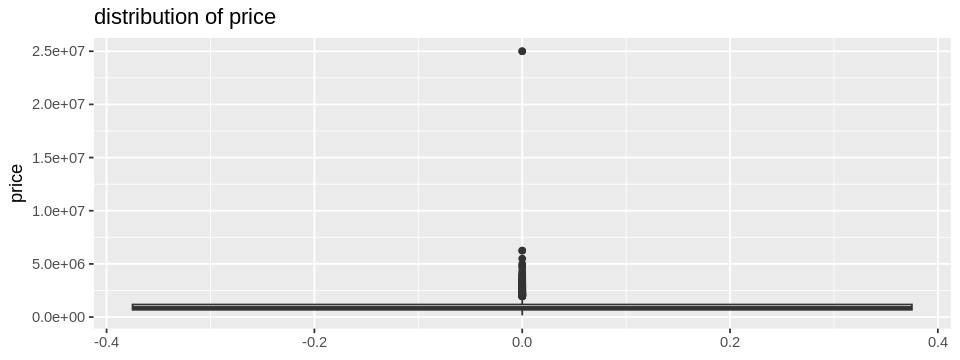

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 3)

# shows the outlier
ggplot(clean_data, aes(y = price)) +
  geom_boxplot() +
  labs(title = "distribution of price")

# use the IQR method to find the outliers
q1 = quantile(clean_data$price, 0.25)
q3 = quantile(clean_data$price, 0.75)
potential_outlier_threshold =  1.5*(q3-q1)*1.5 + q3
cat(" 1.5*IQR + Q3 is", potential_outlier_threshold)

# check for the potential outlier
potential_outlier <- clean_data %>% filter(price != 2.5e7)

# data without the potential outlier
no_outlier_data <- clean_data %>% filter(price != 2.5e7)

From the initial examination, two extreme outliers were identified, notably a house with 2 bedrooms and 1 bathroom priced at USD $25 million. This value lies far beyond the third quartile and is excluded from further visual analysis and modeling due to its potential to distort results.

Outliers can disproportionately influence the regression line, pulling it away from the true trend of the majority of the data. This results in biased parameter estimates, reducing both the accuracy and reliability of the model.

Once linear model is made, outliers will be checked again using the standard residual formula where the outliers are defined as following

$$|e_i^*| > 3 \implies \bigg|\frac{e_{i}}{\hat{\sigma}\sqrt{1-P_{ii}}}\bigg| > 3$$

**Analysis of Continuous Covariates**

Now lets analyze all the continuous covariates and examine their relationship with the price.

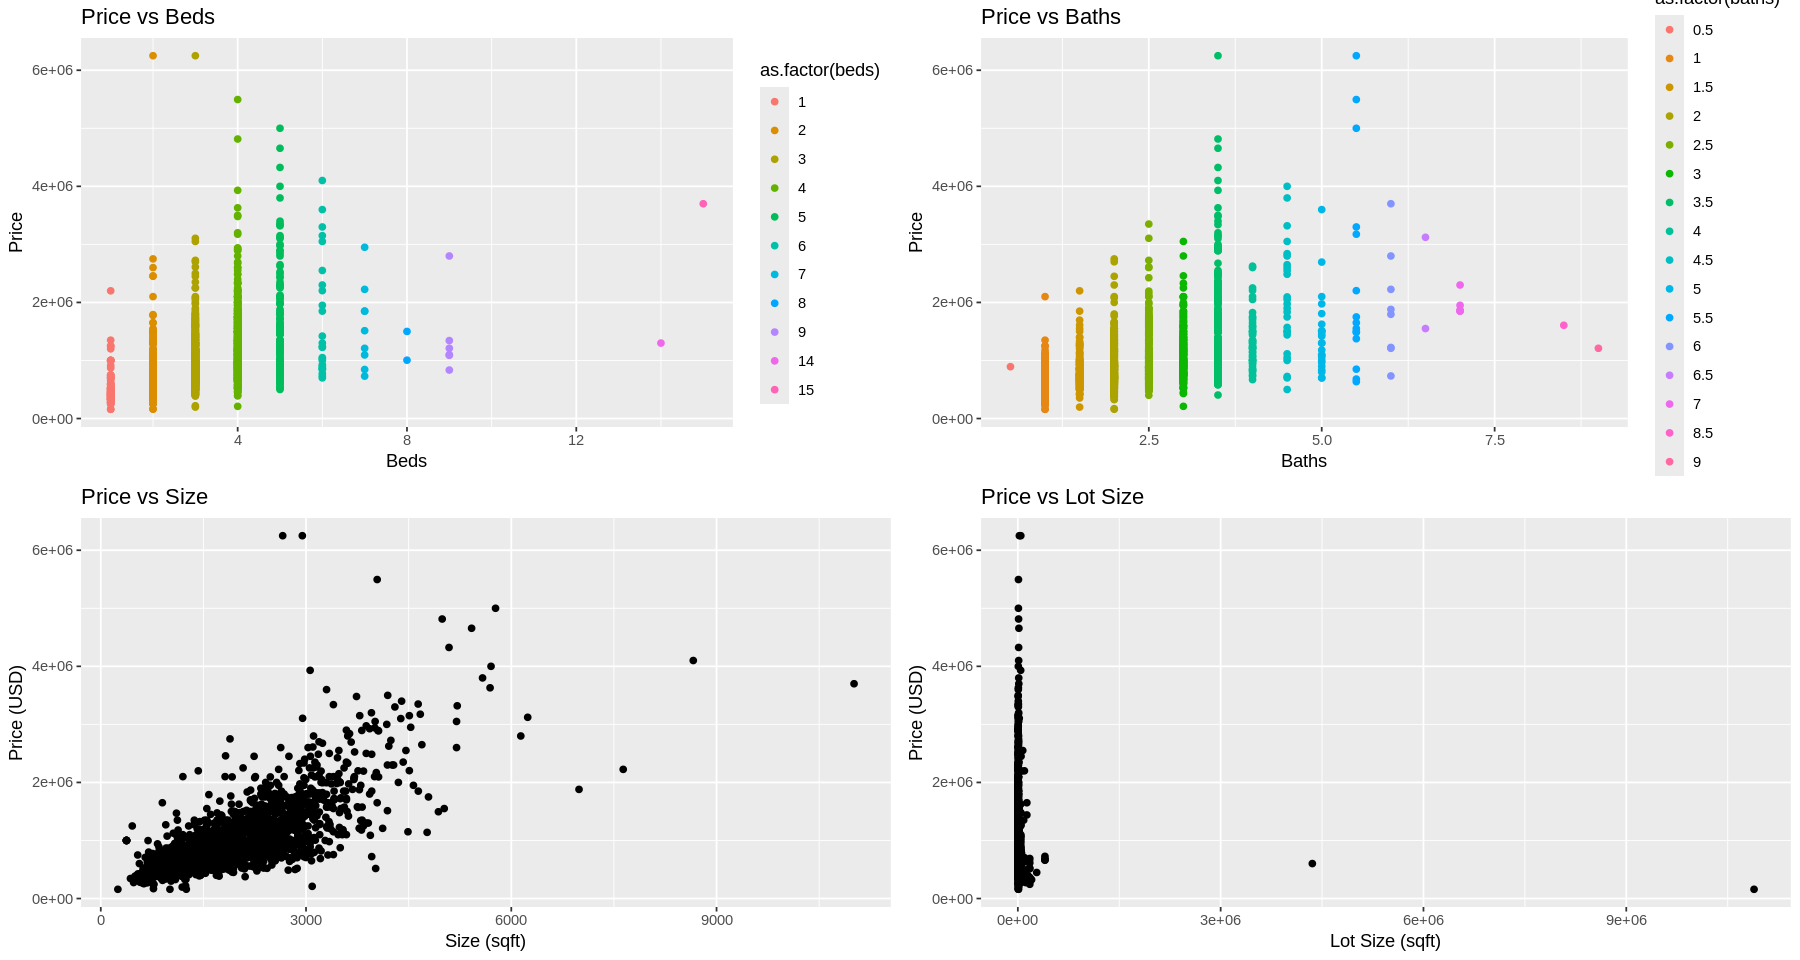

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 8)

# scatterplot of price vs beds
plot1 <- ggplot(no_outlier_data, aes(y = price, x = beds, color = as.factor(beds))) +
  geom_point() +
  labs(title = "Price vs Beds", x = "Beds", y = "Price")

# scatterplot of price vs baths
plot2 <- ggplot(no_outlier_data, aes(x = baths, color = as.factor(baths), y = price)) +
  geom_point() +
  labs(title = "Price vs Baths", x = "Baths", y = "Price")

# Scatterplot of price vs size
plot3 <- ggplot(no_outlier_data, aes(x = size, y = price)) +
  geom_point() +
  labs(title = "Price vs Size", x = "Size (sqft)", y = "Price (USD)")

# Scatterplot of price vs lot_size
plot4 <- ggplot(no_outlier_data, aes(x = lot_size, y = price)) +
  geom_point() +
  labs(title = "Price vs Lot Size", x = "Lot Size (sqft)", y = "Price (USD)")


# Arrange the plots in a 3 by 3 grid
grid.arrange(plot1, plot2, plot3, plot4, nrow=2)

Examining the relationships between price and individual covariates reveals the following insights:

**Price vs. Beds** and **Price vs. Baths**:
- Examining the plots, a moderate positive linear relationship between `price` and `beds` as well as `price` and `baths` can be observed which suggests that houses with more amenities (bedrooms and bathrooms) generally command higher prices.

**Price vs. Size**:
- A strong positive linear relationship can be observed which indicates that larger houses are associated with higher prices, potentially making `size` a key predictor of `price`.

**Price vs. Lot Size**:
- The relationship is obscured by extreme values in `lot_size`, making it difficult to interpret. Applying a log transformation to `lot_size` could mitigate the effect of these extreme values and reveal a clearer relationship between `lot_size` and `price`.

**Log Transformation of Lot Size**

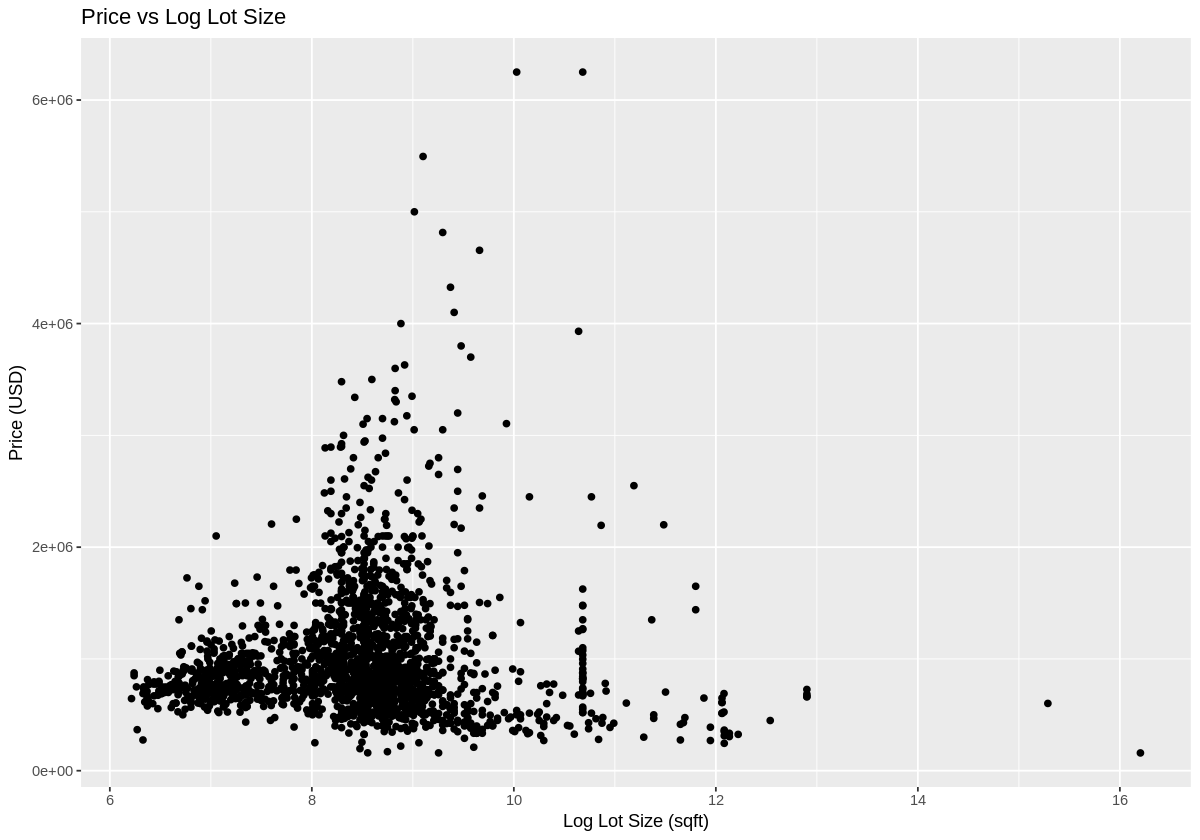

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Scatterplot of price vs log_lot_size
plot5 <- ggplot(no_outlier_data, aes(x = log(lot_size), y = price)) +
  geom_point() +
  labs(title = "Price vs Log Lot Size", x = "Log Lot Size (sqft)", y = "Price (USD)", fill = "Neighborhood")

# Arrange the plots in a 3 by 3 grid
grid.arrange(plot5, nrow=1)

**Price vs. Log Lot Size**

The log-transformed lot size exhibits a weak positive linear relationship with house price based on plot. While this transformation improves interpretability, the relationship remains weak, indicating that `log_lot_size` alone is not a strong predictor of `price`.

Aside from `size`, all other covariates show only weak to moderate positive linear relationships with `price`. The variability suggests that the influence of other factors, such as neighborhood desirability and broader marker conditions play a role in the price of properties.

To further investigate the role of geographical factors, we next examine how house prices vary across neighborhoods. This analysis provides insight into how location impacts housing market trends.


**Analysis of Price by Neighborhood**

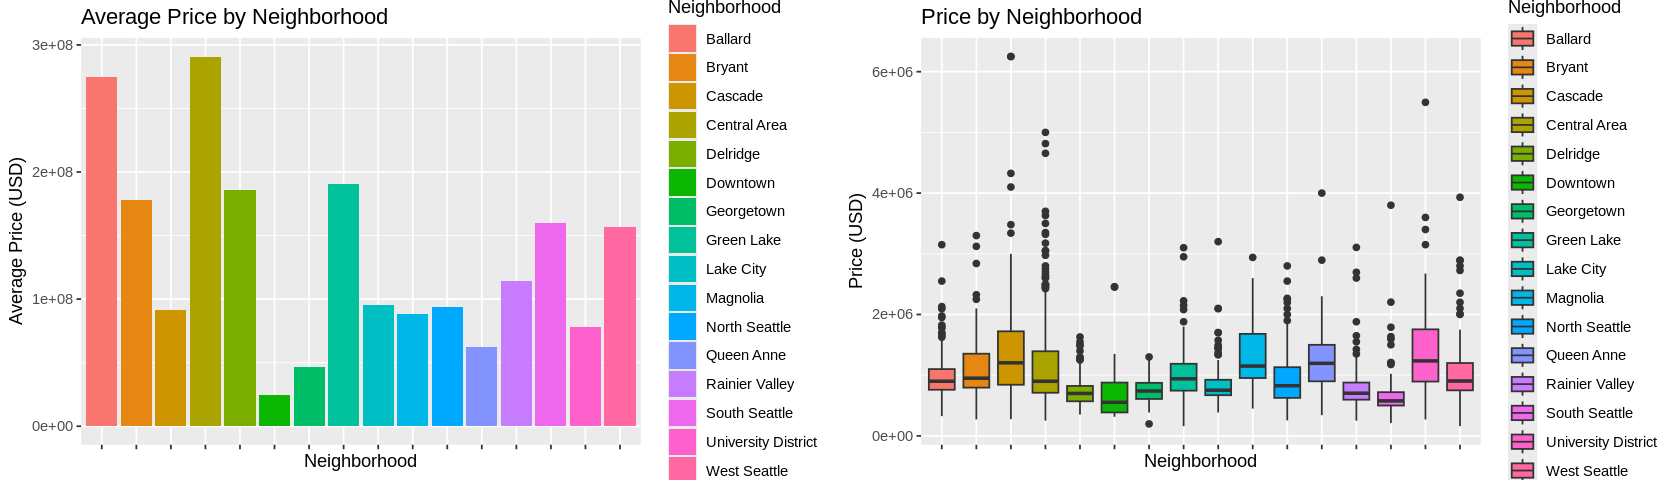

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 4)

# Barplot of average price for each neighborhood
plot6 <- ggplot(data = no_outlier_data, aes(x = as.factor(neighborhood), y = mean(price), fill = as.factor(neighborhood))) +
  geom_bar(stat = "identity") +
  labs(title = "Average Price by Neighborhood", x = "Neighborhood", y = "Average Price (USD)", fill = "Neighborhood") +
  theme(axis.text.x = element_blank())

# # Boxplot of Neighborhood vs price
plot7 <- ggplot(no_outlier_data, aes(x = as.factor(neighborhood), y = price, fill = as.factor(neighborhood))) +
  geom_boxplot() +
  labs(title = "Price by Neighborhood", x = "Neighborhood", y = "Price (USD)", fill = "Neighborhood") +
  theme(axis.text.x = element_blank())

# Arrange the plots in a 3 by 3 grid
grid.arrange(plot6, plot7, nrow=1)

1. **Average Price by Neighborhood**
- Neighborhoods such as Ballard and Central Area exhibit the highest average house prices, while Downtown and Georgetown have the lowest. However, averages can be misleading due to the influence of extreme values.
2. **Price Distribution by Neighborhood**
- Extreme values in Central Area and Ballard inflate their average house prices. By examining the distributions:
Cascade, University District, and Lake City show the highest median house prices.
- Downtown and South Seattle have the lowest median prices.
- This distribution highlights the variability in house prices across neighborhoods and provides a clearer understanding beyond averages.

**Role of Neighborhood**:
The wide price ranges across neighborhoods indicate that location is a critical determinant of house price, offering valuable predictive information for modeling and analysis.




**Conclusion of EDA**

Based on the visualisations above, we have decided to perform the following transformations on the data and add another covariate:
- `log_lot_size` which was done to ensure that the transformed lot size has a linear relation with the response variable (`price`)

In [ ]:
# Transformations
input <- no_outlier_data %>% mutate(log_lot_size = log(lot_size))

## Relationship Between Covariates

To examine the relationships between the continuous covariates and to look for potential multi-collinearity, we will examine the covariance matrix of the covariates.

To explore the relationships among continuous covariates and identify potential multicollinearity, we analyze the covariance matrix. This matrix provides insight into how covariates are related to each other. High covariance values may indicate multicollinearity, which can affect the stability and interpretability of regression coefficients in linear models.

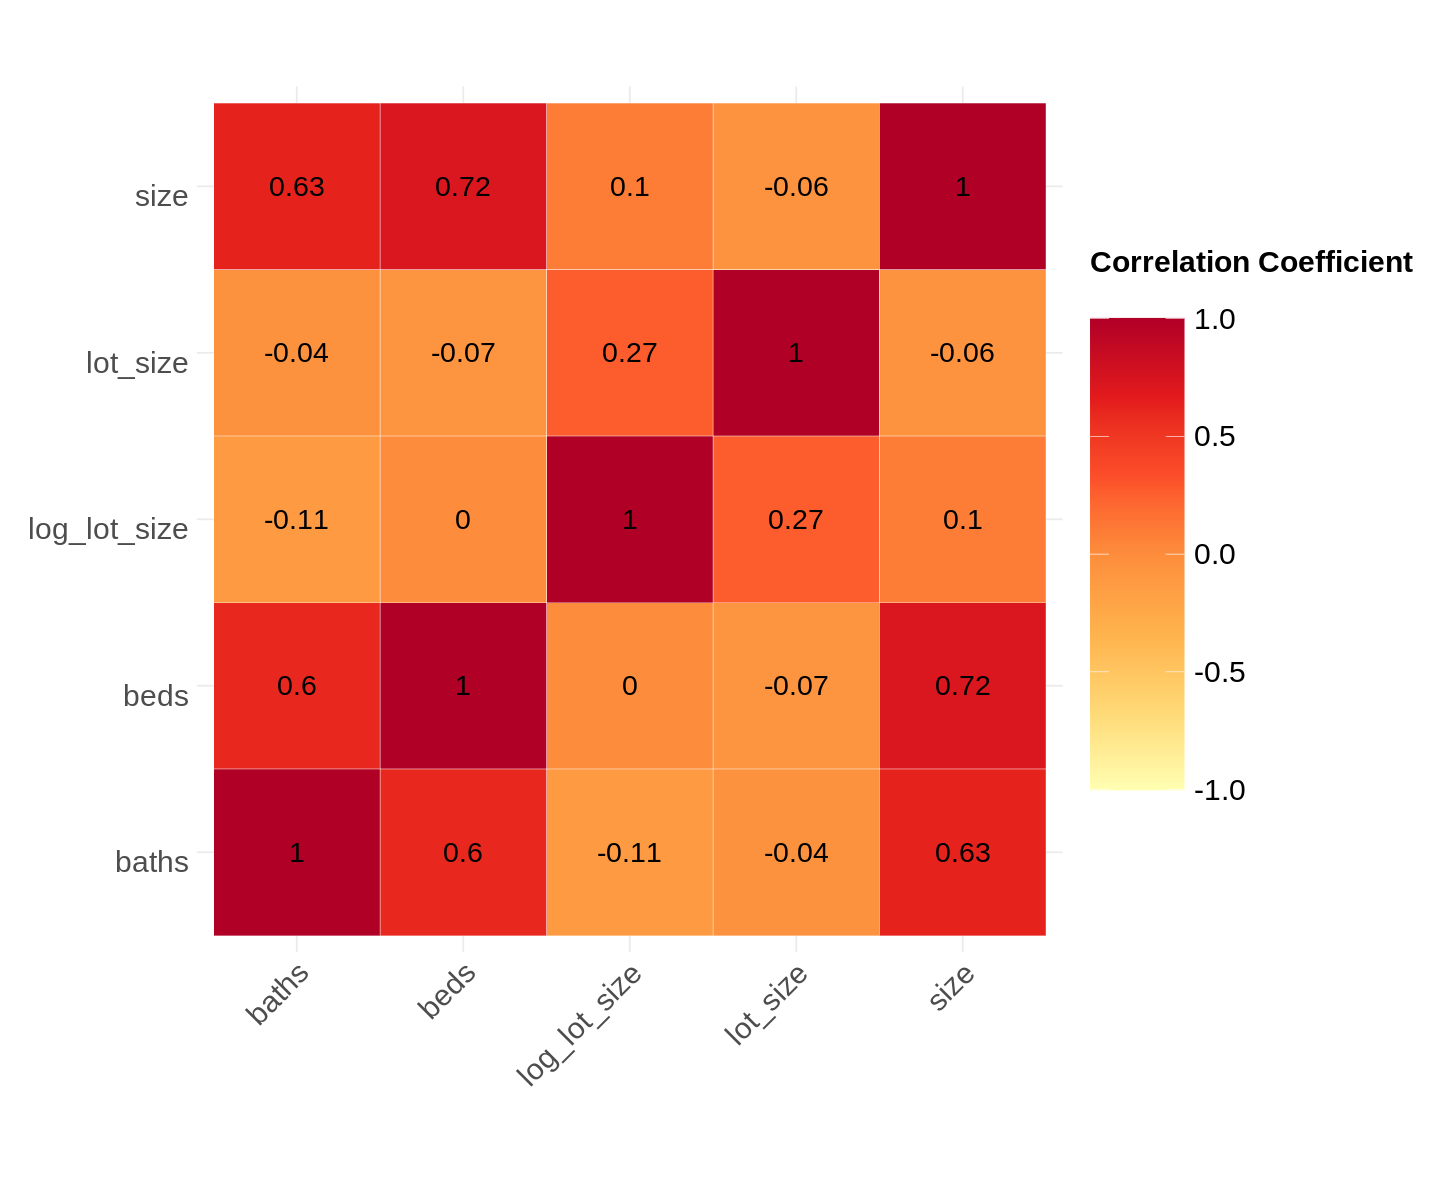

In [ ]:
# Construct covariance matrix
corr_matrix = input |>
              dplyr::select(where(is.numeric), -price) |>
              cor() |>
    as_tibble(rownames = 'var1') |>
    pivot_longer(-var1, names_to = "var2", values_to = "corr")

# Plot covariance matrix
options(repr.plot.width = 12, repr.plot.height = 10)
corr_matrix_plot = corr_matrix |>
  ggplot(aes(x = var1, y = var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller(name = "Correlation Coefficient \n",
    palette = "YlOrRd",
    direction = 1, limits = c(-1, 1)
  ) +
  labs(x = "", y = "") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 18, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 18, hjust = 1
    ),
    legend.title = element_text(size = 18, face = "bold"),
    legend.text = element_text(size = 18),
    legend.key.size = unit(2, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(label = round(corr, 2)), color = "black", size = 6)

# Display the correlation matrix plot
corr_matrix_plot

The correlation matrix reveals notable relationships among some of the continuous covariates.

**High Correlations**
- `beds` and `size`: Correlation of 0.72 suggests a strong linear relationship.
- `baths` and `size`: Correlation of 0.63 indicates a moderately strong relationship.
- `beds` and `baths`: Correlation of 0.60 suggests these variables are also moderately correlated.

**Multicollinearity Concern**:
The high correlations indicate potential multicollinearity when including beds, baths, and size together as covariates in the model. Multicollinearity can destabilize coefficient estimates and reduce interpretability.

**Next Steps:**
To address this concern, we will proceed cautiously and evaluate multicollinearity using Variance Inflation Factor (VIF) after fitting the model. This ensures the model remains robust and interpretable.

With this in mind, we move forward to the Model Selection process.

##Model Selection
To refine our model, we employ a backward selection approach, which iteratively removes the least significant covariate until all remaining predictors are statistically significant at the 5% level. The least significant covariate is determined as the one with the highest p-value exceeding this threshold.


**Backward Selection**

This approach enhances interpretability, ensures only meaningful predictors are retained, and eliminates neighborhoods that do not add predictive value. It also improves model parsimony by reducing complexity while maintaining accuracy.

1. **Initial Model**:
   - Covariates included in the initial model: `baths`, `beds`, `size`, `log_lot_size`, and `neighborhood` (with neighborhoods represented as dummy variables).
2. **Simplifying Neighborhoods**:
   - We will apply a carefully chosen rule to `neighborhood` categorical variable. If a specific neighborhood's dummy variable is the least significant predictor in an iteration, we attempt to group it into a new neighborhood category labeled `Other`, which combines neighborhoods that do not provide useful information to the model.
   - The `Other` category is created to improve the model's parsimony and interpretability.
   - However, if the `Other` neighborhood remains insignificant, we exclude these neighborhoods from the model as well. We will track these dropped neighborhoods  and interpret them as being similar to the baseline neighborhood *Ballard*.
   - This approach allows us to compare the results of the baseline with the dropped neighborhood post-analysis.

In [ ]:
# Perform backward selection based on p-value
backward_selection<- function(data, covariates, response, significance_level = 0.05, max_iterations = 100) {
  curr_iter <- 0
  other_neighborhoods = c()

  while (curr_iter < max_iterations) {
    formula <- paste(response, "~", paste(covariates, collapse = "+"))
    curr_model = lm(formula, data)
    curr_model_summary = summary(curr_model)

    p_values <- coef(curr_model_summary)[, "Pr(>|t|)"]
    p_values <- p_values[!(names(p_values) %in% c("(Intercept)", "neighborhoodOther"))]
    least_significant_p_value <- max(p_values, na.rm = TRUE)
    least_significant_term <- names(which.max(p_values))

    # Check if least significant term is a dummy variable for neighborhood,
    # if it isn't remove it
    if (least_significant_p_value > significance_level) {
      if (grepl("neighborhood", least_significant_term, ignore.case = TRUE)) {
          neighborhood_name <- sub("^neighborhood", "", least_significant_term, ignore.case = TRUE)
          other_neighborhoods = c(other_neighborhoods, neighborhood_name)

          # Mutate data to make this neighborhood in "Other" category
          data <- data %>%
            mutate(
              neighborhood = as.character(neighborhood),
              neighborhood = ifelse(neighborhood == neighborhood_name, "Other", neighborhood)
            ) %>%
            mutate(neighborhood = factor(neighborhood))
      } else {
        # Remove least signiciant covariate
        covariates <- covariates[covariates != least_significant_term]
      }
    } else {
        # Check to see if "other category" is significant and if it's not, remove observations belonging to this category.
        total_p_value = coef(curr_model_summary)[, "Pr(>|t|)"]
        if ("neighborhoodOther" %in% names(total_p_value) &&
             total_p_value[names(total_p_value) == "neighborhoodOther"] > significance_level) {
          data <- data %>% filter(neighborhood != "Other")
          curr_model = lm(formula, data)
        }
        return(list(model = curr_model, modified_data = data, other = other_neighborhoods))
    }
    curr_iter = curr_iter+1
  }
  return(list(model = curr_model, modified_data = data, other = other_neighborhoods))
}


# Create new category "other" for neighborhoods
input$neighborhood <- factor(input$neighborhood, levels = c(levels(data$neighborhood), "Other"))
covariates <- c("lot_size", "log_lot_size", "baths", "beds", "size", "neighborhood")
response <- "price"

# Resulting model
results <- backward_selection(input, covariates, response)
print(results$other)
selected_model <- results$model
summary(selected_model)
modified_data <- results$modified_data

[1] "Downtown"     "Green Lake"   "Queen Anne"   "West Seattle" "Bryant"      
[6] "Central Area"



Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1033983  -167223   -21954   126315  4217970 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      -44305.44  102469.01  -0.432  0.66554    
log_lot_size                      34095.69   11794.51   2.891  0.00391 ** 
baths                            101351.19   14238.97   7.118 1.89e-12 ***
beds                             -69344.61   12964.40  -5.349 1.06e-07 ***
size                                417.91      18.77  22.268  < 2e-16 ***
neighborhoodCascade              334276.41   43406.22   7.701 2.82e-14 ***
neighborhoodDelridge            -227775.46   34122.62  -6.675 3.77e-11 ***
neighborhoodGeorgetown          -274659.14   56062.17  -4.899 1.09e-06 ***
neighborhoodLake City           -128976.51   42667.21  -3.023  0.00256 ** 
neighborhoodMagnolia             118494.99   44245.36   2.678  0.00750 ** 
neighborhoodNo

**Model from Backward Selection**

After several iterations, the final model kept the following predictors:
  - **Continuous predictors**: `beds`, `baths`, `size`, and `log_lot_size`.
  - **Categorical predictors**: Only neighborhoods that had a significant impact on price.

Now lets plot the residuals vs. fitted values and the qqplot to gain more insight into the model.

 the VIF of   are:  1.221805 1.883547 2.166629 2.467042 1.313711 1 1 1 1 9 1.105353 1.372424 1.471947 1.570682 1.015274

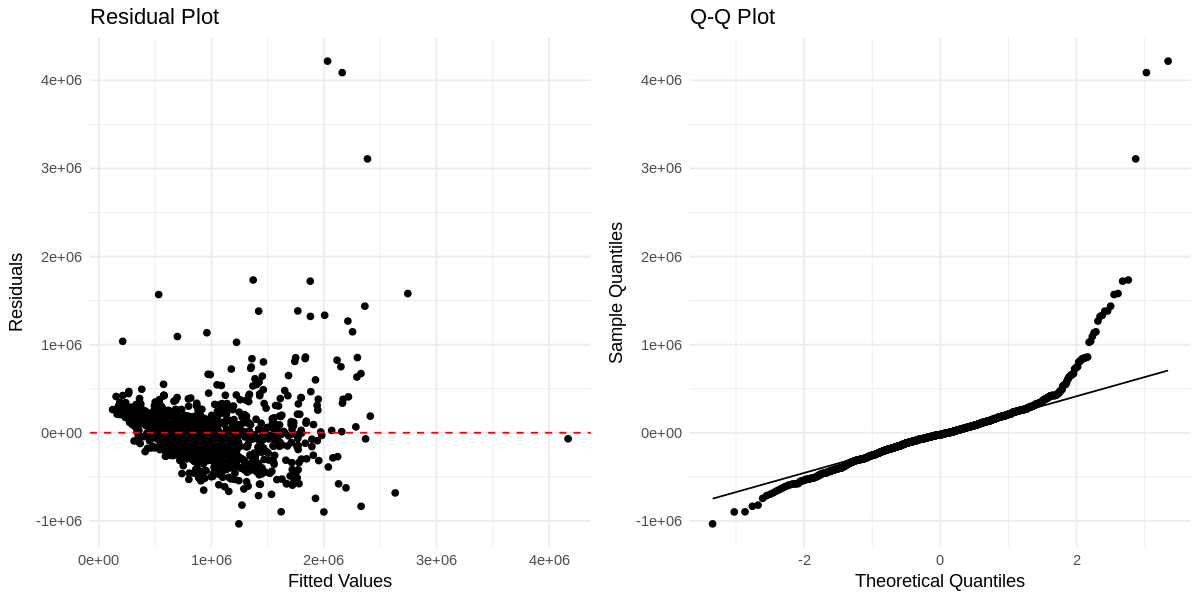

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
# Residual plot
plot1 <- ggplot(selected_model, aes(.fitted, .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot", x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# Q-Q plot
plot2 <- ggplot(selected_model, aes(sample = .resid)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "Q-Q Plot", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()

# VIF of the model
vif_selected <- vif(selected_model)
cat(" the VIF of ", names(vif_selected), " are: ", vif_selected)

grid.arrange(plot1,plot2, nrow=1)

The diagnostic plots reveal violations of key assumptions in the initial linear model:

1. Homoscedasticity:
- The residual plot indicates non-constant variance among residuals.
- A fanning pattern is visible, suggesting that the variance of residuals increases with higher fitted values.
- A moderate negative linear relationship can also be observed among some residuals further confirms heteroscedasticity.

2. Normality:
- The Q-Q plot shows significant deviations from normality specifically near the tails, indicating that the residuals are not normally distributed.
3. Multicollinearity:
- Despite concerns raised by the correlation matrix, the Variance Inflation Factor (VIF) for the covariates is below the threshold of 10, suggesting no significant multicollinearity issues in the model.

**Addressing Violations:**
To address the assumption violations, we propose a transformation of the response variable `price`, such as a log or square root transformation. Transformations can help stabilize variance (addressing heteroscedasticity) and improve the normality of residuals.

## Transforming response variable

**Next Steps:**
- Apply the log and square root transformations to the response variable `price`.
- Reapply the backward selection process to refine the model with the transformed response.
- Reassess model diagnostics (residuals, Q-Q plot, VIF) to ensure the revised model satisfies the assumptions.

Furthermore, we are also removing the datapoints that result in $|e^*_i| > 3$ to account for the outliers present in the data. This will help our model to focus on actual trend and relations present in the data.

In [ ]:
std_residuals <- rstandard(selected_model)

# Filter out the data points with standardized residuals greater than 3 or less than -3
cleaned_input <- input[abs(std_residuals) <= 3, ]
# number of outliers present
sum(abs(std_residuals) <= 3)

# apply sqrt transformation and then backward selection
sqrt_input <- cleaned_input %>% mutate(sqrt_price = sqrt(price)) %>% dplyr::select(-price)
covariates <- c("lot_size", "log_lot_size", "baths", "beds", "size", "neighborhood")
response <- "sqrt_price"
sqrt_selection_results <- backward_selection(sqrt_input, covariates, response)
sqrt_selected_model <- sqrt_selection_results$model
sqrt_other <- sqrt_selection_results$other
summary(sqrt_selected_model)

# apply log transformation and then backward selection
log_input <- cleaned_input %>% mutate(log_price = log(price)) %>% dplyr::select(-price)
covariates1 <- c("lot_size", "log_lot_size", "baths", "beds", "size", "neighborhood")
response1 <- "log_price"
log_selection_results <- backward_selection(log_input, covariates1, response1)
log_selected_model <- log_selection_results$model
log_other <- log_selection_results$other
summary(log_selected_model)


[1] 1192


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-585.56  -71.22   -6.52   60.29 1152.74 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      6.318e+02  1.410e+01  44.803  < 2e-16 ***
lot_size                        -4.379e-04  1.776e-04  -2.466 0.013809 *  
baths                            4.077e+01  5.391e+00   7.564 7.86e-14 ***
beds                            -2.084e+01  5.023e+00  -4.149 3.58e-05 ***
size                             1.815e-01  7.056e-03  25.726  < 2e-16 ***
neighborhoodCascade              1.195e+02  1.699e+01   7.035 3.38e-12 ***
neighborhoodDelridge            -1.131e+02  1.296e+01  -8.726  < 2e-16 ***
neighborhoodGeorgetown          -1.370e+02  2.146e+01  -6.386 2.45e-10 ***
neighborhoodLake City           -5.832e+01  1.619e+01  -3.602 0.000328 ***
neighborhoodMagnolia             6.004e+01  1.690e+01   3.554 0.000395 ***
neighborhoodNorth Seattl


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.52036 -0.11997 -0.00403  0.12615  1.28731 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 1.278e+01  9.801e-02 130.414  < 2e-16 ***
lot_size                   -2.295e-06  4.706e-07  -4.876 1.24e-06 ***
log_lot_size                3.313e-02  1.211e-02   2.736 0.006314 ** 
baths                       8.121e-02  1.047e-02   7.757 1.97e-14 ***
size                        2.966e-04  1.222e-05  24.273  < 2e-16 ***
neighborhoodCascade         1.669e-01  3.104e-02   5.377 9.26e-08 ***
neighborhoodDelridge       -2.628e-01  2.424e-02 -10.838  < 2e-16 ***
neighborhoodGeorgetown     -3.054e-01  3.970e-02  -7.691 3.22e-14 ***
neighborhoodLake City      -1.417e-01  3.035e-02  -4.670 3.37e-06 ***
neighborhoodMagnolia        1.035e-01  3.129e-02   3.307 0.000972 ***
neighborhoodNorth Seattle  -1.403e-01  3.118e-02  -4.498 7.58e-06 ***

**Analysis of Transformations**

The model with `sqrt_price` selected the `lot_size` instead of `log_lot_size` from backward selection but the model with `log_price` selected `lot_size` as well and it didn't select `beds`.

Both plots have similar Adjusted $R^2$ so we are going to check for any linear regression assumption violations again using residual vs. fitted values plot, QQ plot and the $VIF$ of the model.

**Note:** There are two computations for $VIF$ as the code is automated and it accounts for the possibility of `sqrt_selected_model` and `log_selected_model` having different covariates being selected.


 the VIF of   are:  1.051376 1.81717 2.178164 2.350879 1.181342 1 1 1 1 9 1.025366 1.348024 1.475861 1.533258 1.009301  according to the sqrt price model
 the VIF   are:  1.970543 2.362595 1.757214 1.883078 1.254642 1 1 1 1 8 1.40376 1.537074 1.3256 1.372253 1.014279  according to the log price model

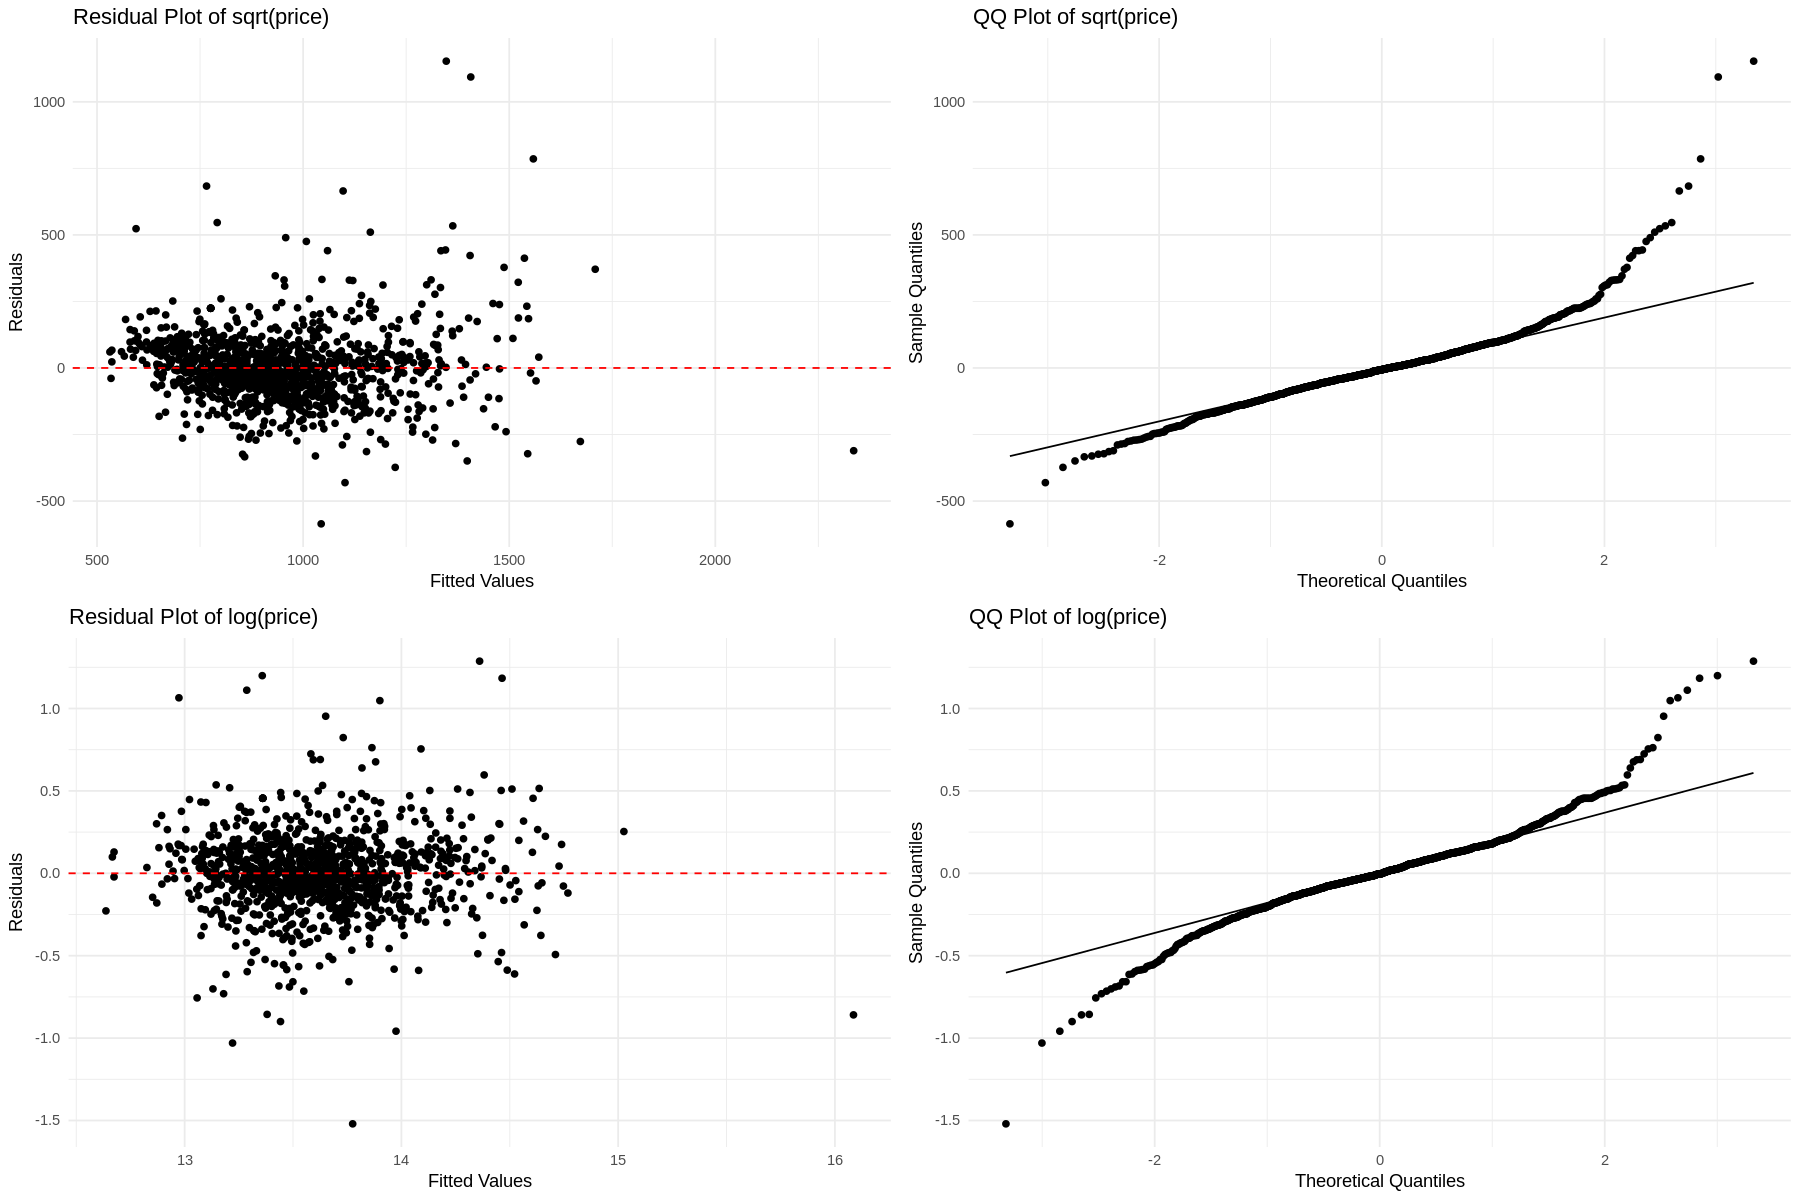

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Residual plot of sqrt(price)
plot1 <- ggplot(sqrt_selected_model, aes(.fitted, .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot of sqrt(price)", x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# Q-Q plot of sqrt(price)
plot2 <- ggplot(sqrt_selected_model, aes(sample = .resid)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "QQ Plot of sqrt(price)", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()

# VIF of the model of sqrt(price)
vif_selected <- vif(sqrt_selected_model)
cat("\n the VIF of ", names(vif_selected), " are: ", vif_selected, " according to the sqrt price model")


# Residual plot  log(price)
plot3 <- ggplot(log_selected_model, aes(.fitted, .resid)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residual Plot of log(price)", x = "Fitted Values", y = "Residuals") +
  theme_minimal()

# Q-Q plot log(price)
plot4 <- ggplot(log_selected_model, aes(sample = .resid)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "QQ Plot of log(price)", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()

# VIF of the model log(price)
vif_selected <- vif(log_selected_model)
cat("\n the VIF ", names(vif_selected), " are: ", vif_selected, " according to the log price model")

grid.arrange(plot1,plot2,plot3,plot4, nrow=2)

**Final Model**

Both models (response `sqrt_price` and `log_price`) successfully address the initial assumption violations and exhibit improvements.
- Both models show an increased adjusted $R^2$, indicating better explanatory power and improved fit.
- Both models demonstrate minimal heteroscedasticity, with relatively constant variance across fitted values.
- Residuals for both models follow a normal distribution for most values, with slight deviations at the tails. The model with `sqrt_price` has slightly less deviation from the normal model, making it a better canditate.
- No Variation Inflation Factor (VIF) exceeds threshold of 10, confirming that multi-collinearity is not a concern in either model.  



Since the model with `sqrt_price` follows the normal distribution more closely than the model with `log_price`, we will select the model with `sqrt_price` as our final model.

We can conclude that there is not strong evidence to suggest that our model violates any assumptions of the linear regression model and it follows the normal distribution with constant variance.

**Conclusion of Model Selection:**

The model with `sqrt_price` as the responce is the better canditate and meets all the assumptions of linear regression model.
- Residuals are approximately normal.
- Variance is relatively constant.
- No significant multicollinearity is present.
- This model is robust and provides reliable insights into the relationships between covariates and house prices.





In [ ]:
# Set final model
final_model <- sqrt_selected_model
summary(final_model)


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-585.56  -71.22   -6.52   60.29 1152.74 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      6.318e+02  1.410e+01  44.803  < 2e-16 ***
lot_size                        -4.379e-04  1.776e-04  -2.466 0.013809 *  
baths                            4.077e+01  5.391e+00   7.564 7.86e-14 ***
beds                            -2.084e+01  5.023e+00  -4.149 3.58e-05 ***
size                             1.815e-01  7.056e-03  25.726  < 2e-16 ***
neighborhoodCascade              1.195e+02  1.699e+01   7.035 3.38e-12 ***
neighborhoodDelridge            -1.131e+02  1.296e+01  -8.726  < 2e-16 ***
neighborhoodGeorgetown          -1.370e+02  2.146e+01  -6.386 2.45e-10 ***
neighborhoodLake City           -5.832e+01  1.619e+01  -3.602 0.000328 ***
neighborhoodMagnolia             6.004e+01  1.690e+01   3.554 0.000395 ***
neighborhoodNorth Seattl

# Findings



**Base-line Neighborhood**

The baseline neighborhood in our model is *Ballard*.

In [ ]:
sqrt_other

[1] "Green Lake"   "Downtown"     "Central Area" "Queen Anne"   "Bryant"      
[6] "West Seattle"

Any inference we make for the baseline neighborhood *Ballard* likely apply to *Green Lake*, *Downtown*, *Central Area*, *Queen Anne*, *Bryant*, and *West Seattle* as well since these are neighborhoods whose effects were statistically insignificant in our model so they liekly exhibit similar characteristics as the baseline neighborhood *Ballard*. Moving forward, these neighborhoods will be grouped together and referred to collectively as the baseline neighborhoods. Any inferences made about Ballard can be reasonably applied to this group, as the model suggests they share comparable influences on house prices.




**Neighborhoods**
1. Magnolia
- Properties located in *Cascade* neighborhood are associated with a strong positive effect of $+119.5$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *Delridge* neighborhood are associated with a strong negative effect of $-113.1$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *Georgetown* neighborhood are associated with a strong negative effect of $-137.0$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *Lake City* neighborhood are associated with a negative effect of $-58.3$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *Magnolia* neighborhood are associated with a positive effect of $+60.0$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *North Seattle* neighborhood are associated with a negative effect of $-46.9$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *Ranier Valley* neighborhood are associated with a strong negative effect of $-100.8$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *South Seattle* neighborhood are associated with a strong negative effect of $-181.4$ on `sqrt_price` relative to the baseline neighborhoods.
- Properties located in *University District* neighborhood are associated with a positive effect of $+56.4$ on `sqrt_price` relative to the baseline neighborhoods.

**Beds**
- A 1-unit increase in `beds` reduces `sqrt_price` by $-20.8$.

**Baths**
- A 1-unit increase in `baths` increases `sqrt_price` by $40.8$.

**Size**
- A 1-unit increase in `size` reduces `sqrt_price` by $0.18$.

**Lot Size**
- A 1-unit increase in `lot_size` reduces `sqrt_price` by $-0.00044$.



**Inferences**

**Expensive Neighborhoods:**
Properties in University District, Cascade, and Magnolia are relatively expensive compared to the baseline neighborhoods. These neighborhoods may be prestigious in Seattle due to factors like:
- High-quality community amenities.
- High-end properties.
- Low crime rates.

These areas are good candidates for high-budget home-buyers seeking premium locations.

**Cheaper Neighborhoods:**
Neighborhoods such as Delridge, Georgetown, Rainier Valley, and South Seattle have lower property prices compared to the baseline neighborhoods. Potential contributing factors include:
- Lower-end housing stock.
- Lack of community infrastructure.
- Isolation from basic services or higher crime rates.

These observations warrant further investigation into studying the influence of these external factors to explain why houses are cheaper in these neighborhoods.

**Baseline Neighborhoods:**
Baseline neighborhoods (e.g., Ballard, Green Lake, Downtown) offer relatively affordable homes. They may appeal to middle-class buyers looking to settle in Seattle.

**Covariate Effects**
1. **Bathrooms:**
Among the continuous covariates, baths have the greatest positive impact on
price. Homes with more bathrooms are generally more expensive, suggesting that bathrooms are a key driver of property valuation in Seattle.

2. **Size:** Larger homes (‘size‘) have a significant positive effect on prices, indicating that buyers place a high value on spacious properties. This trend is consistent across all neighborhoods.

3. **Lot Size:** Larger lot sizes exhibit a slight negative effect on prices, suggesting that buyers do not prioritize lot size as much as other factors like bathrooms or overall house size. This may reflect a preference for compact properties in urban settings.

4. **Bedrooms:** Surprisingly, more beds have a slight negative impact on
price according to our model. This counterintuitive result contrasts with the positive correlation observed during exploratory analysis, possibly indicating the influence of a confounding variable or an interaction term with another covariate, requiring further investigation. It suggests that buyers in Seattle may prioritize functionality and layout over the sheer number of bedrooms, reflecting a preference for smaller, well-designed homes.



# Conclusion

Our initial research question was to study the physical and geographical factors which influence house prices in Seatle. To address this question we fit a linear regression model through backward selection and adjusted $R^2$ our model to ensure it doesn't violate any assumptions of the linear regression model. Our final model includes covariates `beds`, `baths`, `size`, `lot_size`, and `neighborhoods` and our model achieved an adjusted $R^2$ 0.6847. From our model we made various inferences to explain our model and our findings suggest that home-buyers in Seattle value features like bathrooms and house size over lot size and bedroom count. Neighborhood desirability plays a critical role, with some areas commanding higher property price due to factors such as percieved prestige, safety, and amenities. This analysis provides good insight for potential home-buyers looking to settle down in Seattle. Further investigation into confounding factors affecting the relationships between beds and price could provide deeper insights into buyer preferences.

Our initial research question sought to identify the physical and geographical factors influencing house prices in Seattle. To address this, we developed a linear regression model using backward selection and made necessary adjustments to ensure it met the assumptions of linear regression. The final model includes `beds`, `baths`, `size`, `lot_size`, and `neighborhoods` as covariates and achieved an adjusted $R^2$ of 0.685, highlighting the models robust explanatory power. From our model, we made various inferences to explain our model and our findings suggest that bathrooms and house size are significant drivers of property prices, highlighting buyer preferences for functional and spacious homes. Lot size has a minimal negative effect, and additional bedrooms slightly decrease prices, which is counter-intuitive to real-world scenarios which suggests the need for further investigation into potential confounding factors.
Neighborhood desirability also plays a pivotal role in determining house prices. Areas like University District, Cascade, and Magnolia command higher prices due to perceived prestige, safety, and amenities. Conversely, neighborhoods such as Delridge, Georgetown, and South Seattle are associated with lower prices, potentially due to factors like limited infrastructure or higher crime rates. The findings provide actionable insights for potential home-buyers, investors, and policymakers. Buyers can prioritize neighborhoods and features that align with their budgets and preferences, while policymakers can focus on addressing disparities across neighborhoods.

This study offers a detailed understanding of Seattle’s housing market and highlights the interplay between physical features and neighborhood characteristics. Future research could explore external influences, such as market dynamics and socio-economic factors, to uncover deeper trends and enhance decision-making for stakeholders.